# 16. 다음에 볼 영화 예측하기

session based recommendation은 말 그대로 세션 데이터를 기반으로 유저가 다음에 클릭할 아이템은 예측하는 추천 시스템을 말한다.   
세션은 접근하기 쉬운 쿠키에 귀중한 데이터를 맡기기 어려워 서버에 저장하는것이다. 이 정보로 개개인을 구별할 수 있다.   
로그인으로 비유하면 로그인 시도할 때 입력한 정보를 세션에 보내고, 만약 성공했으면 서버에서 쿠키를 보내 개인의 브라우저에 정보를 담는다. 그리고 다른 페이지를 넘어다닐 때 쿠키를 확인하고 로그인을 유지한다. 만약 쿠키를 지우면 사용자의 로그인 정보를 서버에서 세션의 형태로 갖고는 있지만, 해당 브라우저에서 로그인한 사람이 맞는지 파악이 안되어 로그아웃이 된다.   

이를 기반으로 다음에 볼 영화를 예측해보자. 데이터셋은 `MovieLens 1M Dataset`을 이용하자.

# 1. 데이터 불러오기

In [1]:
import pandas
import tensorflow
from datetime import datetime
import datetime as dt
from pathlib import Path
import os
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data

/opt/conda/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,UserId,ItemId,Rating,Time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


데이터프레임을 정렬해보자.

In [3]:
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해준다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


유저 식별이 가능한 `UserId`, 영화 식별이 가능한 `ItemId`, 영화의 평점 `Rating`, timestamp의 `Time`이 있다. 

# 2. 전처리

### Session Length

먼저 유저의 수와 영화 아이템 수를 파악해보자.

In [4]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

유저당 몇 개의 영화를 평가했는지 파악해보자.

In [5]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

session을 통해 데이터셋의 특징을 알아보자.

In [6]:
session_length.median(), session_length.mean() # 중앙값과 평균

(96.0, 165.5975165562914)

In [7]:
session_length.min(), session_length.max() # 최소값, 최대값

(20, 2314)

In [8]:
session_length.quantile(0.999) # 백분위 수

1343.181000000005

세션의 길이 99.9%를 살펴보면 1343이란 수가 나오지만 max값은 2314란 값이 나왔다. 이를 한번 살펴보자.

In [9]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [10]:
# 주석을 해제하고 실행하면 모든 row가 출력되어 결과물 확인이 가능하다.
# pd.set_option('display.max_row', None) 
check_df = data[data['UserId']==long_session]
check_df

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


꾸준히 평점을 매기고 있는 모습을 확인할 수 있다. 한 가지 의문이 드는점은 동일한 Time 인데, 여러 개의 평점을 매기고 있다.   

데이터프레임의 Time column은 초 단위인데, 이렇게 빨리 체크한걸 보면 이는 조사를 대충한게 아닐까? 일단 이를 인지하고 넘어가자.   

session_length의 size를 파악해보자.

In [11]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

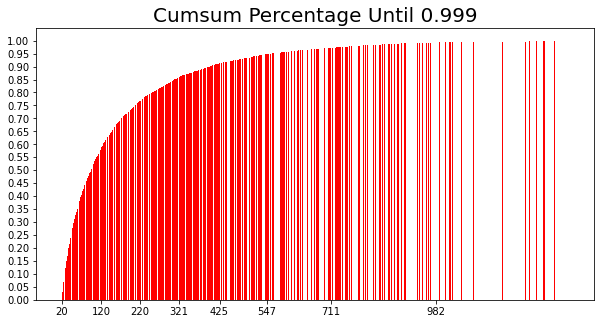

In [12]:
plt.figure(figsize=(10, 5))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index[::100], size=10)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

길이 기준 하위 99.9%까지 분포 누적합을 시각화한 결과물이다. 

### Session Time

시간 관련 데이터를 이해해보자. Time column은 UTC, 1970년 1월 1일부터 초 단위의 시간이 기재되어 있다.

In [13]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [14]:
print(datetime.fromtimestamp(oldest).strftime("%Y-%m-%d %H:%M:%S"))
print(datetime.fromtimestamp(latest).strftime("%Y-%m-%d %H:%M:%S"))

2000-04-25 23:05:32
2003-02-28 17:49:50


__Session Based Recommendation__ 특징상 최근에 얻은 데이터를 토대로 유저들에게 추천을 해줘야 한다. 사용자들의 소비 패턴이 시간에 따라 쉽고 빠르게 달라지기 때문이다. 하지만 영화의 경우 IT 기계같은 사이클이 빠른 애들보다 비교적 많이 느리므로 lastest로부터 365일 기준으로 얻은 데이터만 사용하자.

In [15]:
data = data.sort_values(['Time','UserId'])
data

,UserId,ItemId,Rating,Time
1000138,6040,858,4,956703932
999873,6040,593,5,956703954
1000153,6040,2384,4,956703954
1000007,6040,1961,4,956703977
1000192,6040,2019,5,956703977
...,...,...,...,...
825793,4958,2399,1,1046454338
825438,4958,1407,5,1046454443
825724,4958,3264,4,1046454548
825731,4958,2634,3,1046454548


In [16]:
data = data[['UserId','ItemId','Rating','Time']]
data

,UserId,ItemId,Rating,Time
1000138,6040,858,4,956703932
999873,6040,593,5,956703954
1000153,6040,2384,4,956703954
1000007,6040,1961,4,956703977
1000192,6040,2019,5,956703977
...,...,...,...,...
825793,4958,2399,1,1046454338
825438,4958,1407,5,1046454443
825724,4958,3264,4,1046454548
825731,4958,2634,3,1046454548


In [17]:
temp = 60*60*24*365 # 초*분*시간*일
month_ago = latest - temp
print(datetime.fromtimestamp(month_ago).strftime("%Y-%m-%d %H:%M:%S"))
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

2002-02-28 17:49:50


,UserId,ItemId,Rating,Time
348285,2041,1213,4,1014923199
348057,2041,2300,4,1014923242
347973,2041,2692,5,1014923314
347787,2041,2208,5,1014923499
348165,2041,1923,3,1014923681
...,...,...,...,...
825793,4958,2399,1,1046454338
825438,4958,1407,5,1046454443
825724,4958,3264,4,1046454548
825731,4958,2634,3,1046454548


### Cleaning

영화의 선호도를 체크하는 Rating을 보고 보통 이상인 3점 이상만 남기고 나머지는 버리자.

In [18]:
ratings_filtering_df = data[data['Rating']>=3]
ratings_filtering_df

,UserId,ItemId,Rating,Time
348285,2041,1213,4,1014923199
348057,2041,2300,4,1014923242
347973,2041,2692,5,1014923314
347787,2041,2208,5,1014923499
348165,2041,1923,3,1014923681
...,...,...,...,...
825526,4958,3489,4,1046454320
825438,4958,1407,5,1046454443
825724,4958,3264,4,1046454548
825731,4958,2634,3,1046454548


In [19]:
ratings_filtering_df = ratings_filtering_df.sort_values(['UserId'])
ratings_filtering_df

,UserId,ItemId,Rating,Time
5200,36,2269,5,1040544350
5076,36,595,4,1040545109
5126,36,1295,4,1040545109
5180,36,3639,4,1040545125
5211,36,2774,4,1016224902
...,...,...,...,...
992522,5996,2989,4,1020110717
992571,5996,3247,4,1020110717
992787,5996,1091,3,1020110814
992283,5996,3086,5,1020108866


### Train, Valid, Test split

추천 시스템은 지금을 잘 예측하는게 중요하다. __Session time__ 에서 말한것처럼 사용자들의 소비 패턴이 시간에 따라 쉽고 빠르게 달라지기 때문이다. 그래서 sesstion based recommendation에서 기간에 따라 train, valid, test set을 나누기도 한다.   

이번 자료에서는 총 365일의 데이터셋에서 train을 305일, valid 30일, test 30일로 나눈다음 진행해보자.

In [20]:
ratings_filtering_df['Time'].min(), ratings_filtering_df['Time'].max()

(1014923199, 1046454590)

In [21]:
datetime.fromtimestamp(ratings_filtering_df['Time'].min()).strftime("min time is %Y-%m-%d %H:%M:%S"), datetime.fromtimestamp(ratings_filtering_df['Time'].max()).strftime("max time is %Y-%m-%d %H:%M:%S")

('min time is 2002-02-28 19:06:39', 'max time is 2003-02-28 17:49:50')

In [22]:
data = data[data['Time'] > month_ago]

In [23]:
data.shape

(21704, 4)

In [24]:
data['Time'].max()

1046454590

In [25]:
data.groupby('UserId')['Time'].max()

UserId
36      1040545125
59      1041968335
65      1041090068
102     1043799175
104     1016055781
           ...    
5948    1046437932
5949    1027297425
5950    1046369858
5956    1033358097
5996    1036428955
Name: Time, Length: 498, dtype: int64

In [26]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    temp = 60*60*24*n_days # dt.timedelta(n_days)
    
#     session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
#     session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index
    session_in_train = session_last_time[session_last_time < final_time - temp].index
    session_in_test = session_last_time[session_last_time >= final_time - temp].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
#     after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [27]:
tr, test = split_by_date(ratings_filtering_df, n_days=30)
tr, val = split_by_date(tr, n_days=30)

In [28]:
print(tr['Time'].max()), print(tr['Time'].min())
print(datetime.fromtimestamp(tr['Time'].min()).strftime("tr min time is %Y-%m-%d %H:%M:%S"))
print(datetime.fromtimestamp(tr['Time'].max()).strftime("tr max time is %Y-%m-%d %H:%M:%S"))

print(val['Time'].max()), print(val['Time'].min())
print(datetime.fromtimestamp(val['Time'].min()).strftime("val min time is %Y-%m-%d %H:%M:%S"))
print(datetime.fromtimestamp(val['Time'].max()).strftime("val max time is %Y-%m-%d %H:%M:%S"))
print(test['Time'].max()), print(test['Time'].min())
print(datetime.fromtimestamp(test['Time'].min()).strftime("test min time is %Y-%m-%d %H:%M:%S"))
print(datetime.fromtimestamp(test['Time'].max()).strftime("test max time is %Y-%m-%d %H:%M:%S"))

1041267244
1014923199
tr min time is 2002-02-28 19:06:39
tr max time is 2002-12-30 16:54:04
1043859613
1041272462
val min time is 2002-12-30 18:21:02
val max time is 2003-01-29 17:00:13
1046454590
1043869051
test min time is 2003-01-29 19:37:31
test max time is 2003-02-28 17:49:50


In [29]:
def min_to_day(data: pd.DataFrame):
    temp_b = datetime.fromtimestamp(data['Time'].min()).strftime("\n min time is %Y-%m-%d %H:%M:%S")
    return temp_b

def max_to_day(data: pd.DataFrame):
    temp_a = datetime.fromtimestamp(data['Time'].max()).strftime("\n max time is %Y-%m-%d %H:%M:%S")
    return temp_a

def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n'
          f'\t min time to day : {min_to_day(data)}\n'
          f'\t max time to day : {max_to_day(data)}\n')

In [30]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 14833
	 Sessions: 467
	 Items: 2606
	 First Time : 1014923199
	 Last Time : 1041267244
	 min time to day : 
 min time is 2002-02-28 19:06:39
	 max time to day : 
 max time is 2002-12-30 16:54:04

* valid Set Stats Info
	 Events: 1496
	 Sessions: 132
	 Items: 976
	 First Time : 1041272462
	 Last Time : 1043859613
	 min time to day : 
 min time is 2002-12-30 18:21:02
	 max time to day : 
 max time is 2003-01-29 17:00:13

* test Set Stats Info
	 Events: 1238
	 Sessions: 98
	 Items: 845
	 First Time : 1043869051
	 Last Time : 1046454590
	 min time to day : 
 min time is 2003-01-29 19:37:31
	 max time to day : 
 max time is 2003-02-28 17:49:50



```
tr min time is 2002-02-28 19:06:39
tr max time is 2002-12-30 02:26:14

val min time is 2002-02-28 23:32:05
val max time is 2003-01-29 03:00:40

test min time is 2002-03-01 04:03:30
test max time is 2003-02-28 17:49:50
```
~~결과를 보면 min time이 이상하다. 해결하려고 이런 저런 시도를 했지만 불가능했다. sesstions, items를 보면 예상대로 나눠진거같아 일단 진행했다.~~   
UserID를 기준으로 session을 나누듯이 나눠서 생긴 일이다. Time을 기준으로 나누니 해결했다.

In [31]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

/tmp/ipykernel_96483/703867482.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.


In [32]:
save_path = data_path / 'ex'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

데이터를 준비하고 저장하는 과정까지 마쳤다.

# 3. 미니 배치 구성

[SESSION-BASED RECOMMENDATIONS WITH RECURRENT NEURAL NETWORKS](https://arxiv.org/pdf/1511.06939v4.pdf)을 활용해서 모델을 만들자. GRU4REC이라고 하고 Sesstion data에 처음으로 RNN 계열 모델을 적용했다.   
큰 특징으로는 RNN 계열의 모델에서 Embedding layer를 사용하지 않았을 때 가장 성능이 좋았다고 한다. 그래서 이번에도 원-핫 인코딩을 사용해보자.
![](https://recbole.io/docs/_images/gru4rec.png)

### Session parallel mini batches
Session을 보면 길이가 제각각이다. 이들은 한 세션이 끝날때까지 대기하는 특징을 갖고 있다. 그래서 병렬적으로 계산하자고 적용한게 session parallel mini batches이다.   

__Ranking Loss__   
session based recommendation Task를 여러 아이템 중 다음 아이템이 무엇인지 classification하는 task로 생각할 수도 있다.   
여러 아이템을 관련도 순으로 랭킹을 매겨 높은 랭킹의 아이템을 추천하는 task로 생각할 수도 있다.   
추천 시스템 연구 분야에서는 이렇게 Ranking을 맞추는 objective function에 대한 연구가 있었고 논문의 저자도 이런 Loss를 사용했다.   
이번 자료에서는 Classification Task를 보고 Cross-Entropy Loss를 사용했다. 

In [33]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to ItemId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [34]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
5200,36,2269,5,1040544350,0
5076,36,595,4,1040545109,1
5126,36,1295,4,1040545109,2
5180,36,3639,4,1040545125,3
5211,36,2774,4,1016224902,4
5222,36,296,5,1040545019,5
5256,36,1701,4,1040544350,6
5184,36,2694,3,1040544494,7
5364,36,3786,4,1040544521,8
5280,36,3174,4,1040544685,9


In [35]:
tr_dataset.click_offsets

array([    0,    33,    39,    92,   102,   107,   108,   109,   146,
         147,   149,   174,   180,   199,   210,   231,   281,   350,
         363,   445,   546,   649,   690,   732,   736,   739,   759,
         767,   775,   779,   782,   870,   933,   935,   938,   973,
         985,  1582,  1587,  1607,  1660,  1661,  1662,  1670,  1704,
        1718,  1734,  1742,  1797,  1800,  1848,  1920,  1926,  1955,
        1959,  1961,  2079,  2085,  2091,  2126,  2137,  2256,  2268,
        2310,  2312,  2319,  2322,  2323,  2324,  2326,  2339,  2406,
        2409,  2438,  2473,  2487,  2490,  2491,  2512,  2520,  2521,
        2530,  2861,  2919,  2955,  2956,  2994,  3116,  3159,  3167,
        3180,  3186,  3330,  3346,  3356,  3359,  3364,  3816,  3835,
        3868,  3881,  3882,  3887,  3933,  3936,  3961,  3964,  3972,
        3980,  4041,  4049,  4052,  4091,  4099,  4193,  4226,  4227,
        4230,  4245,  4300,  4326,  4356,  4453,  4511,  4540,  4541,
        4586,  4595,

In [36]:
tr_dataset.session_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

train 데이터로 `SessionDataset` 객체를 만들고 인스턴스 변수들을 살펴보자. `click_offsets` 변수는 각 세션이 시작된 인덱스를 담고 있다. `session_idx` 변수는 각 세션을 인덱싱한 `np.array`이다.

### SessionDataLoader   
`SessionDataset` 객체를 받아 Session Parallel mini batch를 만드는 클래스를 만들자.   
`__iter__` 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 `yield`한다. mask는 후에 RNN Cell State를 초기화하는데 사용할 것이다.

In [37]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [38]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
5200,36,2269,5,1040544350,0
5076,36,595,4,1040545109,1
5126,36,1295,4,1040545109,2
5180,36,3639,4,1040545125,3
5211,36,2774,4,1016224902,4
5222,36,296,5,1040545019,5
5256,36,1701,4,1040544350,6
5184,36,2694,3,1040544494,7
5364,36,3786,4,1040544521,8
5280,36,3174,4,1040544685,9


In [39]:
iter_ex = iter(tr_data_loader)

In [40]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 33 39 89]
Label Item Idx are :       [ 1 34 40 87]
Previous Masked Input Idx are []


반복 실행하면 `next`가 계속 다음 데이터를 만든다.

# 4. 모델 구성

__Evaluation Metric__   
모델 성능에 대한 지표로 precision이나 recall이 있다.   
sesstion based recommendation task의 예를들어 모델이 k개의 아이템을 제시했을 때, 유저가 클릭, 구매한 n개의 아이템이 많아야 좋다. 이 때문에 recall의 개념을 확장한 `recall@k` 지표, precision의 개념을 확장한 `Mean Average Precision@k` 지표 등을 사용한다.   
추천에서는 몇 번째로 맞추느냐도 중요하다. 예를들어 구글에서 검색했을 때 원하는 결과가 1페이지 말고 2페이지에 나온다면 유저의 반응이 크게 떨어진다. 따라서 순서에 민감한 `MRR`, `NDCG` 같은 지표도 사용한다.   
이번 자료에서는 `MRR`, `Recall@k`를 사용하자. `MRR`은 정답 아이템이 나온 순번의 역수 값이다. 이는 정답 아이템이 추천 결과 앞쪽 순번에 나오면 지표가 높아지고 뒤쪽에 나오거나 안나오면 지표가 낮아짐을 의미한다.

In [41]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

__Model Architecture__   
모델 구조 설계하기

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [43]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [44]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

# 5. 모델 학습

In [45]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [46]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 2606)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      398700    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 2606)                132906    
Total params: 531,606
Trainable params: 531,606
Non-trainable params: 0
_________________________________________________________________


Evaluation:  14%|█▍        | 3/21 [00:01<00:07,  2.55it/s]


	 - Recall@20 epoch 1: 0.041667
	 - MRR@20    epoch 1: 0.004193



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.22it/s]


	 - Recall@20 epoch 2: 0.072917
	 - MRR@20    epoch 2: 0.012191



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.34it/s]


	 - Recall@20 epoch 3: 0.046875
	 - MRR@20    epoch 3: 0.009084



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.32it/s]


	 - Recall@20 epoch 4: 0.052083
	 - MRR@20    epoch 4: 0.012220



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.34it/s]

	 - Recall@20 epoch 5: 0.057292
	 - MRR@20    epoch 5: 0.010136



# 6. 모델 테스트

In [47]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   6%|▌         | 1/17 [00:00<00:04,  3.22it/s]

	 - Recall@20: 0.015625
	 - MRR@20: 0.005208



---

### drop_rate, lr 값 수정

In [48]:
args2 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.3, lr=0.001, epochs=5, k=20)
model2 = create_model(args2)
train_model(model2, args2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 2606)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      398700    
_________________________________________________________________
dropout_1 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (64, 2606)                132906    
Total params: 531,606
Trainable params: 531,606
Non-trainable params: 0
_________________________________________________________________


Evaluation:  14%|█▍        | 3/21 [00:01<00:06,  2.67it/s]


	 - Recall@20 epoch 1: 0.041667
	 - MRR@20    epoch 1: 0.003748



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.03it/s]


	 - Recall@20 epoch 2: 0.057292
	 - MRR@20    epoch 2: 0.006549



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.31it/s]


	 - Recall@20 epoch 3: 0.046875
	 - MRR@20    epoch 3: 0.008154



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.26it/s]


	 - Recall@20 epoch 4: 0.052083
	 - MRR@20    epoch 4: 0.008402



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.30it/s]

	 - Recall@20 epoch 5: 0.057292
	 - MRR@20    epoch 5: 0.009022



In [49]:
test_model(model2, args2, test)

Evaluation:   6%|▌         | 1/17 [00:00<00:04,  3.32it/s]

	 - Recall@20: 0.046875
	 - MRR@20: 0.008247



---

### drop_rate, epochs 값 수정(1)

In [50]:
args3 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.5, lr=0.001, epochs=10, k=20)
model3 = create_model(args3)
train_model(model3, args3)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 2606)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      398700    
_________________________________________________________________
dropout_2 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (64, 2606)                132906    
Total params: 531,606
Trainable params: 531,606
Non-trainable params: 0
_________________________________________________________________


Evaluation:  14%|█▍        | 3/21 [00:01<00:06,  2.67it/s]


	 - Recall@20 epoch 1: 0.031250
	 - MRR@20    epoch 1: 0.007163



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.25it/s]


	 - Recall@20 epoch 2: 0.046875
	 - MRR@20    epoch 2: 0.007797



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.25it/s]


	 - Recall@20 epoch 3: 0.062500
	 - MRR@20    epoch 3: 0.008776



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.25it/s]


	 - Recall@20 epoch 4: 0.052083
	 - MRR@20    epoch 4: 0.008354



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.24it/s]


	 - Recall@20 epoch 5: 0.041667
	 - MRR@20    epoch 5: 0.008321



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.23it/s]


	 - Recall@20 epoch 6: 0.046875
	 - MRR@20    epoch 6: 0.009597



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.20it/s]


	 - Recall@20 epoch 7: 0.046875
	 - MRR@20    epoch 7: 0.008578



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.05it/s]


	 - Recall@20 epoch 8: 0.041667
	 - MRR@20    epoch 8: 0.009822



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.23it/s]


	 - Recall@20 epoch 9: 0.036458
	 - MRR@20    epoch 9: 0.005725



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.13it/s]

	 - Recall@20 epoch 10: 0.031250
	 - MRR@20    epoch 10: 0.005489



In [51]:
test_model(model3, args3, test)

Evaluation:   6%|▌         | 1/17 [00:00<00:05,  3.06it/s]

	 - Recall@20: 0.015625
	 - MRR@20: 0.007812



---

### drop_rate, epochs 값 수정(2)

In [52]:
args4 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.3, lr=0.001, epochs=10, k=20)
model4 = create_model(args4)
train_model(model4, args4)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1, 2606)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      398700    
_________________________________________________________________
dropout_3 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (64, 2606)                132906    
Total params: 531,606
Trainable params: 531,606
Non-trainable params: 0
_________________________________________________________________


Evaluation:  14%|█▍        | 3/21 [00:01<00:06,  2.63it/s]


	 - Recall@20 epoch 1: 0.036458
	 - MRR@20    epoch 1: 0.003716



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.16it/s]


	 - Recall@20 epoch 2: 0.057292
	 - MRR@20    epoch 2: 0.006839



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.19it/s]


	 - Recall@20 epoch 3: 0.057292
	 - MRR@20    epoch 3: 0.007078



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.17it/s]


	 - Recall@20 epoch 4: 0.057292
	 - MRR@20    epoch 4: 0.008707



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.18it/s]


	 - Recall@20 epoch 5: 0.057292
	 - MRR@20    epoch 5: 0.007831



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.11it/s]


	 - Recall@20 epoch 6: 0.052083
	 - MRR@20    epoch 6: 0.008455



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.20it/s]


	 - Recall@20 epoch 7: 0.052083
	 - MRR@20    epoch 7: 0.008411



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.08it/s]


	 - Recall@20 epoch 8: 0.052083
	 - MRR@20    epoch 8: 0.008561



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.21it/s]


	 - Recall@20 epoch 9: 0.052083
	 - MRR@20    epoch 9: 0.011185



Evaluation:  14%|█▍        | 3/21 [00:00<00:05,  3.09it/s]

	 - Recall@20 epoch 10: 0.046875
	 - MRR@20    epoch 10: 0.010782



In [53]:
test_model(model4, args4, test)

Evaluation:   6%|▌         | 1/17 [00:00<00:04,  3.22it/s]

	 - Recall@20: 0.031250
	 - MRR@20: 0.018750



# 총 정리

`Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)`
```
- Recall@20: 0.015625
- MRR@20: 0.005208
```
> 학습 과정을 보니 결과값이 높아졌다가 다시 낮아지는 경향이 보인다. 그래서 오버피팅의 경향을 줄이기 위해 drop_rate 값을 올렸다.

`Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.3, lr=0.001, epochs=5, k=20)`
```
- Recall@20: 0.046875
- MRR@20: 0.008247
```
> 학습 경과가 좋게 나왔고, 더 극적인 상황을 확인하기 위해 drop_rate 값과 epochs를 올렸다.

`Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.5, lr=0.001, epochs=10, k=20)`
```
- Recall@20: 0.015625
- MRR@20: 0.007812
```
> drop_rate 값을 너무 올렸다보다, 학습 과정도 값이 좋아졌다가 급격하게 안좋아지는 모습을 확인할 수 있다.

`Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.3, lr=0.001, epochs=10, k=20)`
```
- Recall@20: 0.031250
- MRR@20: 0.018750
```
> 가장 값이 좋았던 2번째와 비교하면 drop_rate는 다시 되돌리고 epochs만 늘렸다. 하지만 학습 과정에서는 epochs가 진행됨에 따라 MRR@20의 값은 증가했지만 Recall@20의 값은 감소했다. 왜 이렇게 나왔을까? 최종 test도 비슷한 양상을 보인다.

# 회고

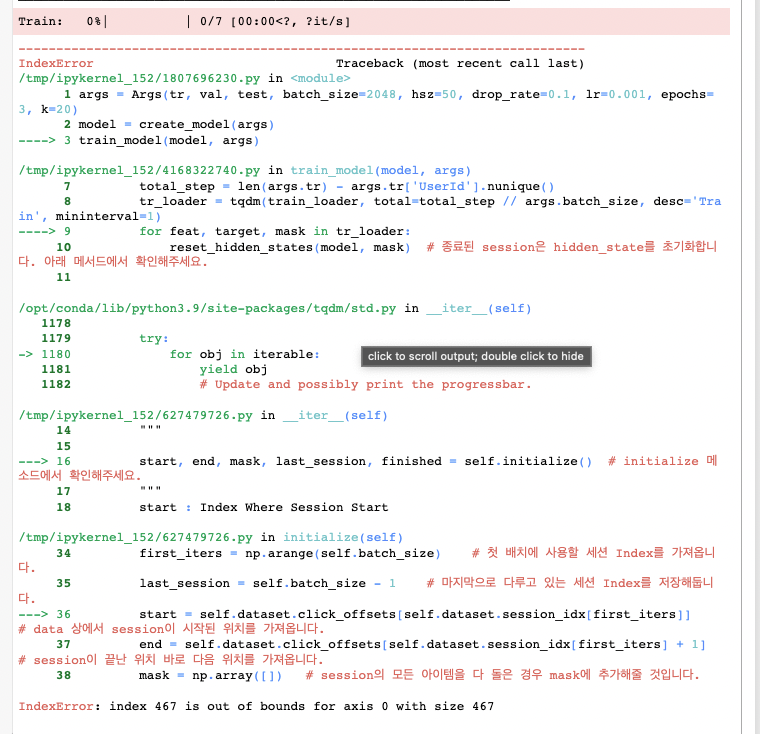

~~`IndexError: index 467 is out of bounds for axis 0 with size 467` 오류가 나왔는데 이는 `train`의 `Sessions`와 같은 값임을 확인했다.~~   
버그를 찾았다. defalut batch_size 값이 너무 커서 해당 파라미터를 64로 줄이니 학습이 됐다. 하지만 다른 버그가 생겼다. 

`split_by_date`로 데이터를 나누는 과정에서 조금 더 합리적인 방안이 있었으면 어땠을까 싶다. tr, test, val을 나눈 일년, 한달, 한달이라는 기간이 그렇게 크게 의미있어 보이지 않다. 

train하는 과정에서 끝까지 안가고 77%에서 멈춘다. 심지어 test의 `Evaluation:   6%` 에서 멈춘다. 이는 뭔가 잘못됨을 직감할 수 있었지만 어떻게 해결할 방안이 떠오르지 않아 이런 저런 시도를 해봤는데 결국 이 값은 해결하지 못했다.

아쉬운게 많고 부족함도 뼈저리게 느낀 프로젝트였다. 아직도 데이터프레임을 핸들링에 미숙하고, 학습도 합리적인 방향으로 못하고 있다. 프로젝트 마감 때문에 급하게 마무리를 진행했지만, 기회가 된다면 비슷한 유형의 session based recommendation이 아니더라도 추천 시스템을 한번 더 진행해보고싶다. ~~그래서 이번에 해커톤에 OCR + 추천 시스템 프로젝트 기획서를 생각중인데 잘 할수있을지 모르겠다.~~